In [81]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json
from scipy.optimize import minimize
import sys 
sys.path.append('./models/')
from useful_functions import differenciate
from scipy.stats import wasserstein_distance
from Mcmc import all_combinaison, create_pandemic, create_params

The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [82]:
start_day = '2020-03-02'
end_day   = '2021-01-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

We use Gerlee et al. to have a moving beta according to the data from the traffic. 

In [83]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


Text(0.5, 1.0, 'Scaling factor for beta based on the mobility data')

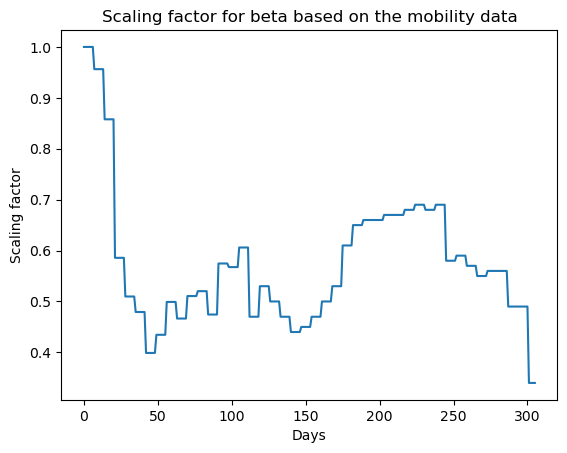

In [84]:
coef_mobility=[1+floatmobility[i] for i in range(len(floatmobility))]
coef_mobility_by_week=np.array([coef_mobility[i//7] for i in range(len(all_days))])
plt.plot(coef_mobility_by_week)
plt.xlabel('Days')
plt.ylabel('Scaling factor')
plt.title('Scaling factor for beta based on the mobility data')

In [85]:
# storing the mobility in a csv file
store_mobility=False
if store_mobility:
    mobility_by_week=np.array([floatmobility[i//7] for i in range(len(all_days))])
    mobility_df=pd.DataFrame({'mobility': mobility_by_week})
    mobility_df.to_csv('mobility_bis.csv')


In [86]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)

Creating parameters that fit the Swedish population

In [87]:
parameters_sweden=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=beta_initial,  
                            location = 'Sweden',
                            pop_infected = 20, #value by default, TOCHANGE
                            
                            )

parameters_sweden_bis=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=0.015,  
                            location = 'Sweden',
                            pop_infected = 100, 
                            
                            )



We want to generate different pandemics to assess the performance of the models. In the next cell, we generate 14 pandemics. Each pandemic is run default parameters except one of them which is doubled, to measure the impact of each parameter on n_severe. 

In [ ]:
if True:    
    all_simuls=[]
    for i in range(14): 
        coefs = [ 1 for _ in range(14)]
        coefs[i]=2
        params_custom = dict(
        pop_size=50000,
        start_day='2020-03-01',
        end_day='2021-03-01',
        pop_type='hybrid',
        beta=0.015,
        location='Sweden',
        pop_infected=10,
        dur={
            'exp2inf': {'dist':'lognormal_int', 'par1':4.5*coefs[0], 'par2':1.5}, # par 1 = mean of the log normal distrib, par 2 = std of the log normal distrib. par1 represents the expected value of the number of days between exposure and infection
            'inf2sym': {'dist':'lognormal_int', 'par1':1.1*coefs[1], 'par2':0.9},
            'sym2sev': {'dist':'lognormal_int', 'par1':6.6*coefs[2], 'par2':4.9},
            'sev2crit': {'dist':'lognormal_int', 'par1':1.5*coefs[3], 'par2':2.0},
            'asym2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[4], 'par2':2.0},
            'mild2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[5], 'par2':2.0},
            'sev2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[6], 'par2':6.3},
            'crit2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[7], 'par2':6.3},
            'crit2die': {'dist':'lognormal_int', 'par1':10.7*coefs[8], 'par2':4.8},
        }, 
        rel_symp_prob= 1.0*coefs[9],
        rel_severe_prob=1.0*coefs[10],
        rel_crit_prob=1.0*coefs[11],
        rel_death_prob=1.0*coefs[12]
        )
        
        # Define mobility coefficients and interventions
        all_days = cv.date_range(params_custom['start_day'], params_custom['end_day'])
        coef_mobility_custom = [1 for _ in range(len(all_days))]
        interventions_custom = cv.change_beta(days=all_days, changes=coef_mobility_custom, do_plot=False)

        # Create and run the simulation
        mysimul = cv.Sim(params_custom, interventions=interventions_custom)
        mysimul.run()
        all_simuls.append(np.array(mysimul.results['n_severe']))
        # Plot results
        plt.plot(mysimul.results['n_severe'])
        plt.xlabel('Day')
        plt.ylabel('Number of severe cases')
        plt.title('Number of severe cases over time with '+ str(i)+' -th parameter changed')
        plt.show()



In [89]:
# normalizing the pandemics
ar1=all_simuls[0]/np.sum(abs(all_simuls[0]))
ar2=all_simuls[1]/np.sum(abs(all_simuls[1]))
ar6=all_simuls[6]/np.sum(all_simuls[6])
ar10=all_simuls[10]/np.sum(all_simuls[10])

Different functions to assess the diversity of a set of pandemics

In [90]:
# function to compare two pandemics: 


def diff_between_2_arrays(array1, array2): # this function punishes the pandemics when they do not have the same amplitude (difference in maximum), but also when their derivatives do not have the same amplitude, and when their second derivatives do not have the same amplitude
    derive1=np.array(differenciate(array1))
    derive2=np.array(differenciate(array2))
    derivee1=np.array(differenciate(derive1))
    derivee2=np.array(differenciate(derive2))
    max1=max(array1)
    max2=max(array2)
    maxder1=max(derive1)
    maxder2=max(derive2)
    maxderder1=max(derivee1)
    maxderder2=max(derivee2)
    ar1_normalized=array1/np.sum(abs(array1))
    ar2_normalized=array2/np.sum(abs(array2))
    der1_normalized=derive1/np.sum(abs(derive1))
    der2_normalized=derive2/np.sum(abs(derive2))
    derder1_normalized=derivee1/np.sum(abs(derivee1))
    derder2_normalized=derivee2/np.sum(abs(derivee2))
    res=[]
    if max1>max2: 
        res.append(max1/max2 -1) # difference of amplitude of the two arrays
    else : 
        res.append(max2/max1-1)
    if maxder1>maxder2:
        res.append(maxder1/maxder2-1) # difference of amplitude of the two derivatives
    else :
        res.append(maxder2/maxder1-1)
    if maxderder1>maxderder2:
        res.append(maxderder1/maxderder2-1) # difference of amplitude of the two second derivatives
    else :
        res.append(maxderder2/maxderder1-1)
    res.append(np.sum([abs(ar1_normalized[i]-ar2_normalized[i]) for i in range(len(ar1_normalized))])) # absolute difference of the two arrays
    res.append(np.sum([abs(der1_normalized[i]-der2_normalized[i]) for i in range(len(der1_normalized))])) # absolute difference of the two derivatives
    res.append(np.sum([abs(derder1_normalized[i]-derder2_normalized[i]) for i in range(len(derder1_normalized))])) # absolute difference of the two second derivatives
    res=np.array(res)
    return np.sum(res**2)
            

def diff_between_2_arrays_2(array1, array2): # same function but with wassertsein distance instead of absolute difference
    derive1=np.array(differenciate(array1))
    derive2=np.array(differenciate(array2))
    derivee1=np.array(differenciate(derive1))
    derivee2=np.array(differenciate(derive2))
    max1=max(array1)
    max2=max(array2)
    maxder1=max(derive1)
    maxder2=max(derive2)
    maxderder1=max(derivee1)
    maxderder2=max(derivee2)
    ar1_normalized=array1/np.sum(abs(array1))
    ar2_normalized=array2/np.sum(abs(array2))
    der1_normalized=derive1/np.sum(abs(derive1))
    der2_normalized=derive2/np.sum(abs(derive2))
    derder1_normalized=derivee1/np.sum(abs(derivee1))
    derder2_normalized=derivee2/np.sum(abs(derivee2))
    res=[]
    if max1>max2: 
        res.append(max1/max2 -1)
    else : 
        res.append(max2/max1-1)
    if maxder1>maxder2:
        res.append(maxder1/maxder2-1)
    else :
        res.append(maxder2/maxder1-1)
    if maxderder1>maxderder2:
        res.append(maxderder1/maxderder2-1)
    else :
        res.append(maxderder2/maxderder1-1)
    res.append(wasserstein_distance(ar1_normalized, ar2_normalized))
    res.append(wasserstein_distance(der1_normalized, der2_normalized))
    res.append(wasserstein_distance(derder1_normalized, derder2_normalized))
    res=np.array(res)
    return np.sum(res**2)

In [91]:
def dissemblance(pandemic1, pandemic2, pandemic3, pandemic4): 
    return diff_between_2_arrays(pandemic1, pandemic2)+diff_between_2_arrays(pandemic1, pandemic3)+diff_between_2_arrays(pandemic1, pandemic4)+diff_between_2_arrays(pandemic2, pandemic3)+diff_between_2_arrays(pandemic2, pandemic4)+diff_between_2_arrays(pandemic3, pandemic4)

def dissemblance_3(pandemic1, pandemic2, pandemic3, pandemic4): 
    return diff_between_2_arrays_2(pandemic1, pandemic2)+diff_between_2_arrays_2(pandemic1, pandemic3)+diff_between_2_arrays_2(pandemic1, pandemic4)+diff_between_2_arrays_2(pandemic2, pandemic3)+diff_between_2_arrays_2(pandemic2, pandemic4)+diff_between_2_arrays_2(pandemic3, pandemic4)


def dissemblance_4(pandemic1, pandemic2, pandemic3, pandemic4): 
    pandemic1_normalized = np.array(pandemic1/sum(np.abs(pandemic1)))
    pandemic2_normalized = np.array(pandemic2/sum(np.abs(pandemic2)))
    pandemic3_normalized = np.array(pandemic3/sum(np.abs(pandemic3)))
    pandemic4_normalized = np.array(pandemic4/sum(np.abs(pandemic4)))
    return wasserstein_distance(pandemic1_normalized, pandemic2_normalized)+wasserstein_distance(pandemic1_normalized, pandemic3_normalized)+wasserstein_distance(pandemic1_normalized, pandemic4_normalized)+wasserstein_distance(pandemic2_normalized, pandemic3_normalized)+wasserstein_distance(pandemic2_normalized, pandemic4_normalized)+wasserstein_distance(pandemic3_normalized, pandemic4_normalized)



Looking for the 4 pandemics that are the most different 

In [92]:
diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    # print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l


0 1 2 3 38.5875388583436
0 1 2 4 40.65617701626744
0 1 2 5 42.42389542207567
0 1 2 10 46.089466683018706
0 1 4 10 47.61054845068788
0 1 5 10 48.6196561813687
0 1 10 12 48.72926301480956
0 2 5 10 49.18689315475542
0 4 10 12 49.77237246240248
0 5 10 12 50.53762278266023


Text(0.5, 1.0, '4 most different simulations for dissemblance1')

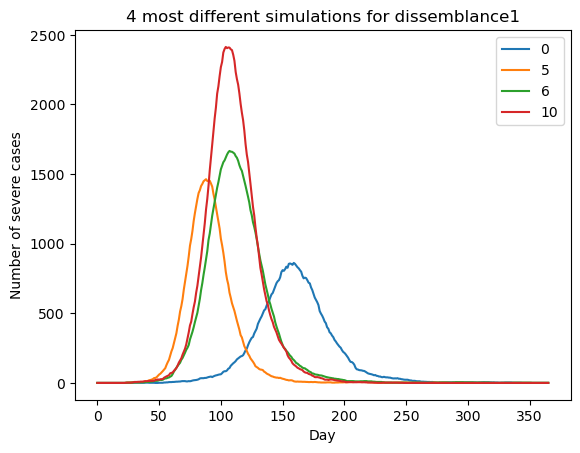

In [93]:
plt.plot(all_simuls[0], label='0')
plt.plot(all_simuls[5], label='5')
plt.plot(all_simuls[6], label='6')
plt.plot(all_simuls[10], label='10')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number of severe cases')
plt.title('4 most different simulations for dissemblance1')

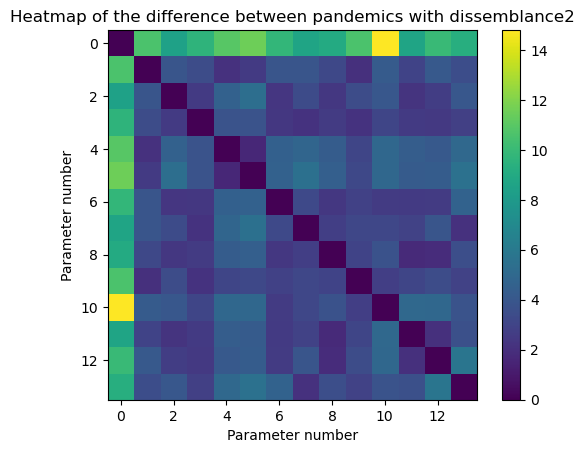

In [94]:
# heatmap of the difference between arrays : 
diffs=[]
for i in range(14): 
    diffs.append([diff_between_2_arrays(all_simuls[i], all_simuls[j]) for j in range(14)])
plt.imshow(diffs)
plt.colorbar()
plt.title('Heatmap of the difference between pandemics with dissemblance2')
plt.xlabel('Parameter number')
plt.ylabel('Parameter number')
# add the namf the loss function o,n the scale : 
plt.show()




As the approach does not take into account the infulence of the variation of different parameters at the same time, we have implemented a MCMC method to find the 4 most relevant parameters to create an important variety of pandemics with the Mcmc.py file

The results were stored in two dictionaries, we extract from them the maxima : 

In [96]:
with open('./results/dicocount_mcmc_3.json', 'r') as fp:
    dicocount_mcmc3 = json.load(fp)
    
with open('./results/dicoloss_mcmc_3.json', 'r') as fp:
    dicoloss_mcmc_3 = json.load(fp)

In [97]:
print('The parameters that maximize the dissemblance is : ')
print(list(dicoloss_mcmc_3.keys())[np.argmax(list(dicoloss_mcmc_3.values()))])
print()
print('The value of the dissemblance is : ')
print(list(dicoloss_mcmc_3.values())[np.argmax(list(dicoloss_mcmc_3.values()))])

The parameters that maximize the dissemblance is : 
[2, 4, 9, 10]

The value of the dissemblance is : 
93553.89346501863


Generation of the different mobilities


In [143]:
mob1=[1 for i in range(len(coef_mobility_by_week))]
mob2=[1+0.5*np.sin(2*np.pi*i/len(coef_mobility_by_week)) for i in range(len(coef_mobility_by_week))]
mob3=[1 for i in range(25)] + [ 0.4 for i in range(70)] + [ 1.2 for i in range(50)] + [1 for i in range(50)] + [ 0.4 for i in range(40)] + [ 1.2 for i in range(71)]

Text(0.5, 1.0, 'Different mobilities')

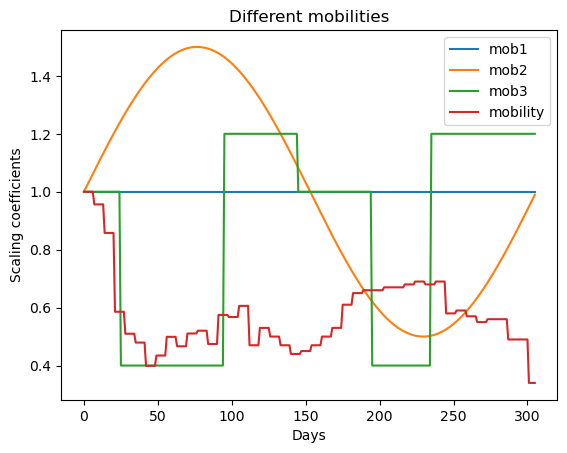

In [145]:
plt.plot(mob1, label='mob1')
plt.plot(mob2, label='mob2')
plt.plot(mob3, label='mob3')
plt.plot(coef_mobility_by_week, label='mobility')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Scaling coefficients')
plt.title('Different mobilities')

With the mobilities and the set of parameters found above, we can generate 81 $\times$ 4 = 324 different pandemics. This is done in the generating_pandemics.py file.

In [99]:
# extracting the pandemics from the csv file
all_pandemics=pd.read_csv('pandemics.csv')
all_pandemics.drop(columns=['Unnamed: 0'], inplace=True)
all_pandemics=np.array(all_pandemics)

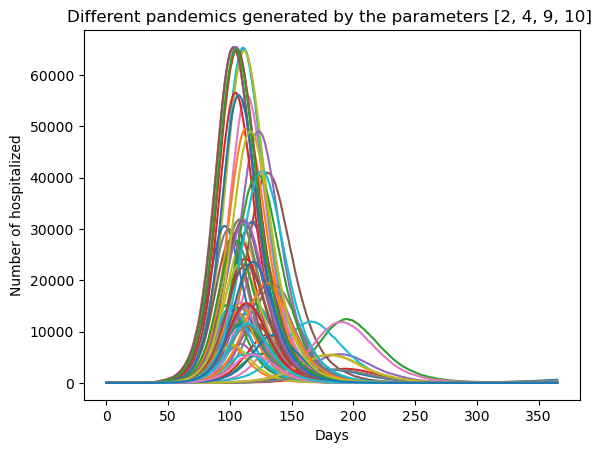

In [102]:
for i in range(81): 
    plt.plot(all_pandemics[i])
plt.title('Different pandemics generated by the parameters [2, 4, 9, 10] ')
plt.xlabel('Days')
plt.ylabel('Number of hospitalized')
plt.show()


Text(0.5, 1.0, '4 random pandemics')

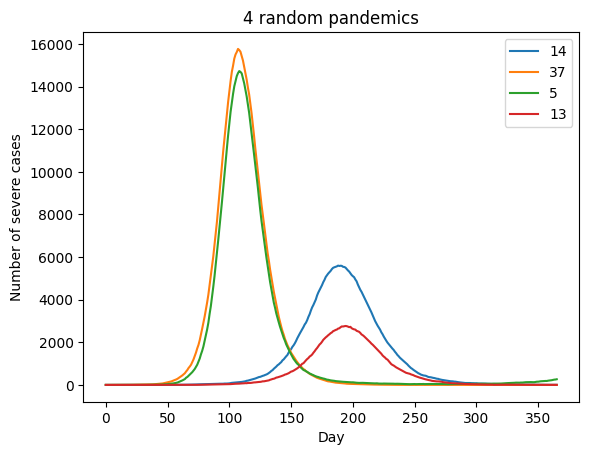

In [35]:
a, b, c, d = np.random.randint(81), np.random.randint(81), np.random.randint(81), np.random.randint(81)
plt.plot(all_pandemics[a], label=str(a))
plt.plot(all_pandemics[b], label=str(b))
plt.plot(all_pandemics[c], label=str(c))
plt.plot(all_pandemics[d], label=str(d))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number of severe cases')
plt.title('4 random pandemics')

Next cells are to create the single pandemics that were used at the beginning to test the models : 

In [169]:
# interventions of changing beta: we create a cv.change_beta object that changes beta everyday according to the values of the traffic circulation. 
cb_mobility = cv.change_beta(days=all_days[:306], changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 
cb_mobility_2= cv.change_beta(days=all_days[:306], changes=coef_mobility_by_week, do_plot=False)

Initializing sim with 1000000 people for 305 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/305) (11.45 s)  ———————————————————— 0%
  Running 2020-03-12 (10/305) (14.55 s)  ———————————————————— 4%
  Running 2020-03-22 (20/305) (17.99 s)  •——————————————————— 7%
  Running 2020-04-01 (30/305) (22.39 s)  ••—————————————————— 10%
  Running 2020-04-11 (40/305) (28.02 s)  ••—————————————————— 13%
  Running 2020-04-21 (50/305) (33.74 s)  •••————————————————— 17%
  Running 2020-05-01 (60/305) (38.11 s)  •••————————————————— 20%
  Running 2020-05-11 (70/305) (43.03 s)  ••••———————————————— 23%
  Running 2020-05-21 (80/305) (48.81 s)  •••••——————————————— 26%
  Running 2020-05-31 (90/305) (52.99 s)  •••••——————————————— 30%
  Running 2020-06-10 (100/305) (57.86 s)  ••••••—————————————— 33%
  Running 2020-06-20 (110/305) (61.69 s)  •••••••————————————— 36%
  Running 2020-06-30 (120/305) (65.68 s)  •••••••————————————— 40%
  Running 2020-07-10 (130/305) (69.59 s)  ••••••

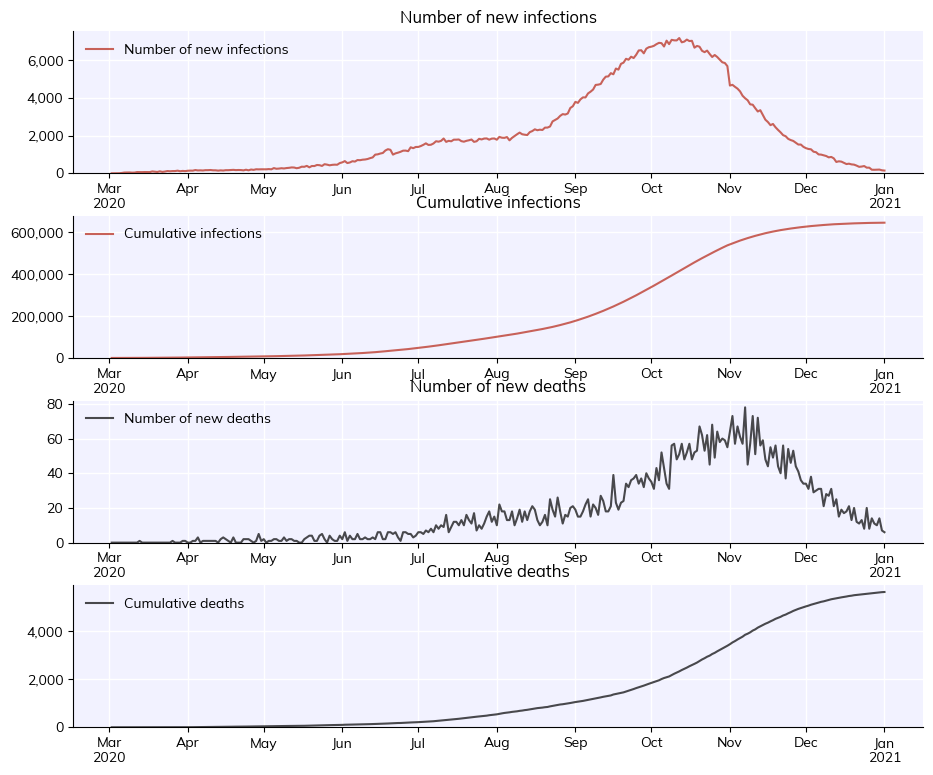

In [155]:
# set run_simul = True to run the simulation and create the n_hospitalized : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions2=cv.Sim(parameters_sweden_bis, interventions=cb_mobility_2)
    my_simulation_sweden_interventions2.run()
    my_simulation_sweden_interventions2.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])

Text(0.5, 1.0, 'Synthetic pandemic for the first tests')

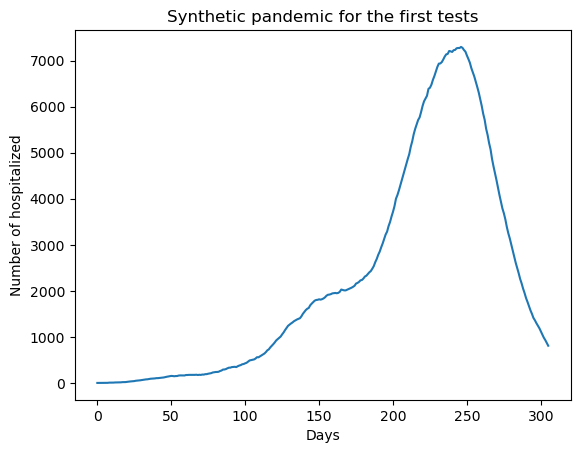

In [161]:
plt.plot(np.array(my_simulation_sweden_interventions2.results['n_severe']))
plt.xlabel('Days')
plt.ylabel('Number of hospitalized')
plt.title('Synthetic pandemic for the first tests')

We can have access to the R_eff of the pandemic: 

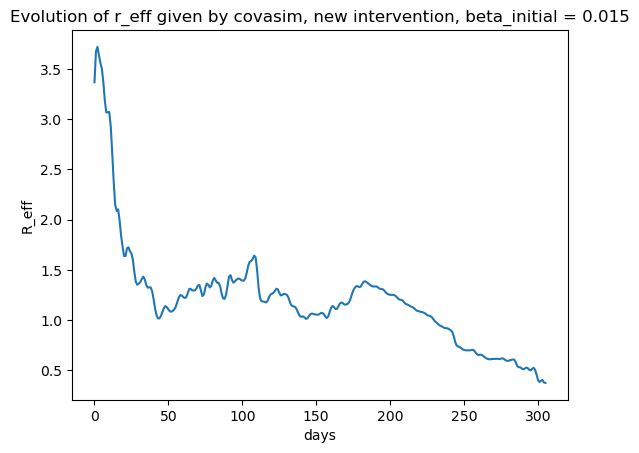

In [162]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions2.compute_r_eff())
plt.title('Evolution of r_eff given by covasim, new intervention, beta_initial = 0.015')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

An other pandemic was used to test some models : 

Initializing sim with 1000000 people for 305 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/305) (11.09 s)  ———————————————————— 0%
  Running 2020-03-12 (10/305) (14.15 s)  ———————————————————— 4%
  Running 2020-03-22 (20/305) (21.34 s)  •——————————————————— 7%
  Running 2020-04-01 (30/305) (33.67 s)  ••—————————————————— 10%
  Running 2020-04-11 (40/305) (46.32 s)  ••—————————————————— 13%
  Running 2020-04-21 (50/305) (58.99 s)  •••————————————————— 17%
  Running 2020-05-01 (60/305) (68.51 s)  •••————————————————— 20%
  Running 2020-05-11 (70/305) (80.15 s)  ••••———————————————— 23%
  Running 2020-05-21 (80/305) (93.89 s)  •••••——————————————— 26%
  Running 2020-05-31 (90/305) (110.93 s)  •••••——————————————— 30%
  Running 2020-06-10 (100/305) (125.00 s)  ••••••—————————————— 33%
  Running 2020-06-20 (110/305) (139.13 s)  •••••••————————————— 36%
  Running 2020-06-30 (120/305) (154.54 s)  •••••••————————————— 40%
  Running 2020-07-10 (130/305) (166.31 s)  •

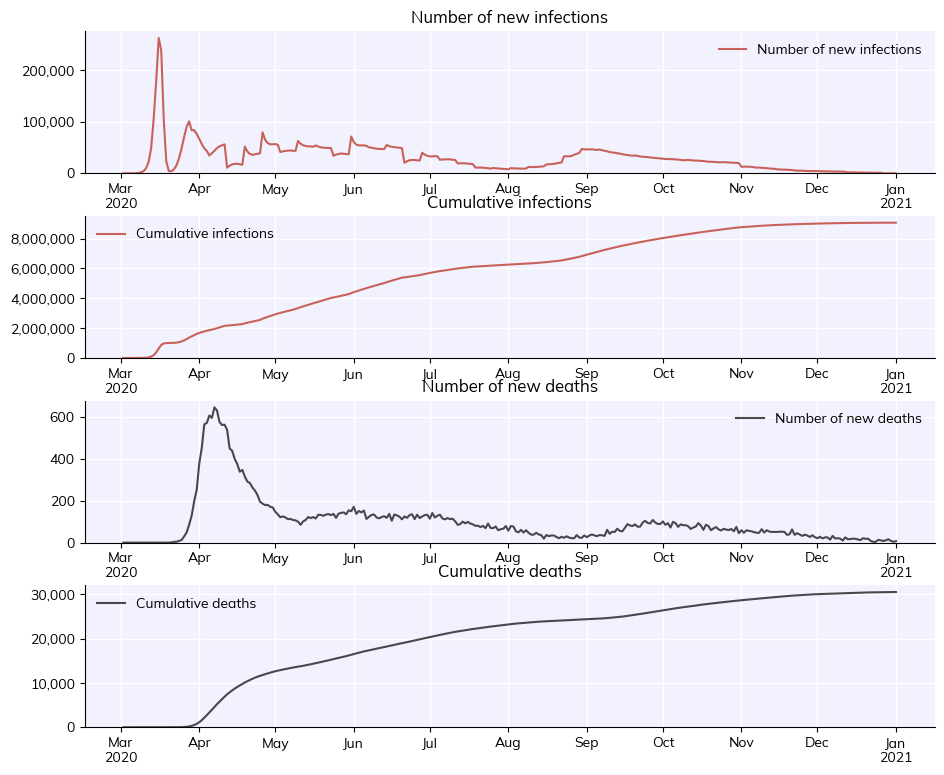

In [170]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
    my_simulation_sweden_interventions.run()
    my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


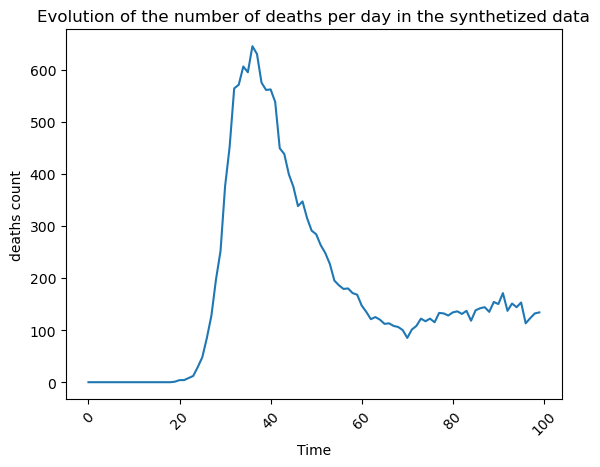

In [172]:
plt.plot(np.array(my_simulation_sweden_interventions.results['new_deaths'])[:100], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')
plt.show()